# Reference

Class Handout, Lee, Chia Jung professor, MDM64001, School of Big Data Management, Soochow University

# Random Forest

In [15]:
import pandas as pd


data = pd.read_csv(r'C:\Users\user\Desktop\day.csv')
df = data.set_index('dteday', drop = True)
x, y = df.iloc[:, 2:13].values, df.iloc[:, -1].values.reshape(-1, 1)

In [16]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 8)

In [3]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators = 200,
                           criterion = 'mse',
                           max_depth = 4,
                           random_state = 10,
                           n_jobs = -1)
rf.fit(x_train, y_train)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=10, verbose=0, warm_start=False)

In [5]:
rf.score(x_train, y_train)

0.8911229638857823

### * Feature Importance

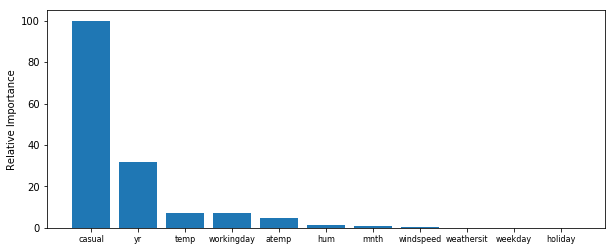

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def plot_feature_importance(feature_importances, title, feature_names):
    feature_importances = 100 * (feature_importances / max(feature_importances))
    index_sorted = np.flipud(np.argsort(feature_importances))
    pos = np.arange(index_sorted.shape[0]) + 0.5
    plt.figure(figsize = (10, 4))
    plt.bar(pos, feature_importances[index_sorted], align = 'center')
    plt.xticks(pos,feature_names[index_sorted], size = 8)
    plt.ylabel('Relative Importance')
    plt.show()
    
    
plot_feature_importance(rf.feature_importances_,
                        'Random forest regressor',
                         df.columns.values[2:13])

# Adaboost

In [33]:
from sklearn.datasets import load_wine


data = load_wine()
x = data['data'][:, [0, 11]]
y = data['target']

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

### * stratify 可以使label種類在train和test資料的比例相同

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 1,
                                                    stratify = y)

### * Adaboost可選擇用何種模型作為base model

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


tree = DecisionTreeClassifier(criterion = 'entropy',
                              max_depth = 2,
                              random_state = 1)
ada=AdaBoostClassifier(base_estimator = tree,
                       n_estimators = 500,
                       learning_rate = 0.1,
                       random_state = 1)
ada=ada.fit(x_train, y_train)

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


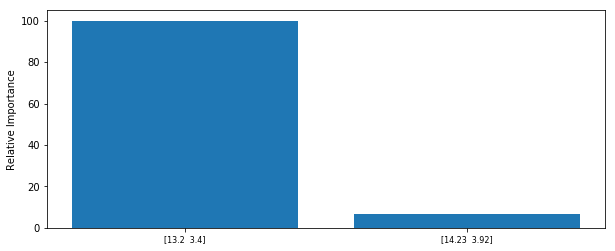

In [24]:
plot_feature_importance(ada.feature_importances_,
                        'Adaboost Classifier',
                         x)

# XGBoost

In [25]:
from xgboost import XGBClassifier


xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
xgbc.score(x_test,y_test)

0.8333333333333334

# Gradient Boosting

In [29]:
from sklearn import ensemble


clf = ensemble.GradientBoostingClassifier()
clf.fit(x_train, y_train) 

In [32]:
clf.score(x_test,y_test)

0.8333333333333334

# LightGBM

In [71]:
import lightgbm as lgb


gbm_model = lgb.LGBMClassifier()
gbm_model.fit(x_train, y_train) 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [74]:
gbm_model.score(x_test,y_test)

0.8333333333333334

# Stacking

In [76]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import r2_score
import pickle


class Stacking:
    
    def __init__(self, x_train, y_train, x_test, y_test, ls_model_stack, model_final, type_label):
        self.trainx = x_train
        self.trainy = y_train
        self.testx = x_test
        self.testy = y_test
        self.ls_model_stack = ls_model_stack
        self.model_final = model_final
        self.type_label = type_label
        self.trainx_stacking_input = None
        self.trainy_stacking = None
        self.trainx_final = None
        self.trainy_final = None
        self.trainx_final_input = None
        self.testx_final_input = np.zeros((x_test.shape[0], len(ls_model_stack)))
    
    def spliting(self):
        if self.type_label == 'discrete':
            self.trainx_stacking_input, self.trainx_final, self.trainy_stacking, self.trainy_final = train_test_split (self.trainx, self.trainy, test_size= 0.3, random_state = 42, stratify = self.trainy)
        elif self.type_label == 'continuous':
            self.trainx_stacking_input, self.trainx_final, self.trainy_stacking, self.trainy_final = train_test_split (self.trainx, self.trainy, test_size= 0.3, random_state = 42)
        self.trainx_final_input = np.zeros((self.trainx_final.shape[0], len(self.ls_model_stack)))   
    
    def modeling_stack_training(self):
        for model, i in zip(self.ls_model_stack, range(len(self.ls_model_stack))):
            model.fit(self.trainx_stacking_input, self.trainy_stacking)
            output = model.predict(self.trainx_final)
            self.trainx_final_input[:, i] = output
            self.save_model(model, str(i))
            
    def modeling_final_training(self):
        self.model_final.fit(self.trainx_final_input, self.trainy_final)
        self.save_model(self.model_final, 'final')
        
    def predict_stack_testing(self):
        for model, i in zip(self.ls_model_stack, range(len(self.ls_model_stack))):
            output = model.predict(self.testx)
            self.testx_final_input[:, i] = output
    
    def predict_final_testing(self):
        self.testy_pred = self.model_final.predict(self.testx_final_input)
        self.testy_pred_prob=self.model_final.predict_proba(self.testx_final_input)
        return self.testy_pred, self.testy_pred_prob
    
    def scoring_testing(self):
        if self.type_label == 'discrete':
            fpr, tpr, thresholds = roc_curve(self.testy, self.testy_pred_prob[:, 1], pos_label=None)
            AUC=auc(fpr, tpr)
            return AUC
        elif self.type_label == 'continuous':
            r2 = r2_score(self.testy, self.testy_pred)
            return r2
    
    def save_model(self, model, filename):
        pickle.dump(model, open(filename, 'wb'))


In [77]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


data = load_wine()
x = data['data'][:, [0, 11]][0: 130]
y = data['target'][0: 130]
le = LabelEncoder()
y = le.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 1,
                                                    stratify = y)

In [78]:
model_stack=[LogisticRegression(),
             DecisionTreeClassifier(),
             CalibratedClassifierCV(LinearSVC())]
model_final = LogisticRegression()
type_label = 'discrete'

In [79]:
stacking = Stacking(x_train, y_train, x_test, y_test, model_stack, model_final, type_label)
stacking.spliting()
stacking.modeling_stack_training()
stacking.modeling_final_training()
stacking.predict_stack_testing()
stacking.predict_final_testing()
stacking.scoring_testing()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to conver

0.9613095238095237